## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [36]:
import os
os.environ["OMP_NUM_THREADS"] = "1"   # 放在 import sklearn 之前
from typing import List, Tuple
import os
from PIL import Image
import numpy as np
from typing import Optional
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
# The structure of data folder.
!ls -l data

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [38]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [39]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X, Y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


### 1.2 Data Noise adding

To test the robustness of the NMF algorithm and compare different algorithm performance, we design salt and pepper noise as the main interference method. The specific method is to randomly select pixels with a ratio of p=0.2 in the image, replace them with black, and control the ratio r=0.2 to white. In the code implementation, we generate a noisy version of the data matrix V and compare it with the original image in subsequent experiments to clearly demonstrate the robustness performance of the NMF algorithm under different noise levels.

In [40]:
def get_image_size(datatype, reduce=1):
    if datatype == 'data/ORL':
        image_size = (112 // reduce, 92 // reduce)   # height, width
    elif datatype == 'data/CroppedYaleB':
        image_size = (192 // reduce, 168 // reduce)
    else:
        raise ValueError(f"Unknown dataset: {datatype}")
    return image_size

In [41]:
def salt_pepper(V: np.ndarray,
                p: float = 0.2,
                r: float = 0.5,
                seed: int | None = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Add  salt noisy to sample matrix 
    Return (V_noisy, noise_mask)；mask=True means it is replaced
    if V have already divided by 255, scaling to [0,1]，then white is 1.0；other wise V.max()（usually 255）。
    """
    V = np.asarray(V, dtype=np.float32)
    d, n = V.shape
    total = d * n
    rng = np.random.default_rng(seed)

    count = int(round(float(p) * total))
    if count <= 0:
        return V.copy(), np.zeros_like(V, dtype=bool)

    # Choose the image label that is going to be replaced
    flat_idx = rng.choice(total, size=count, replace=False)

    # Set r*count to "white", others black 
    salt_count = int(round(float(r) * count))
    salt_count = max(0, min(salt_count, count))
    salt_idx = rng.choice(flat_idx, size=salt_count, replace=False) if salt_count > 0 else np.empty(0, dtype=int)

    V_noisy = V.reshape(-1).copy()
    mask = np.zeros(total, dtype=bool)

    # White value（[0,1] → 1.0；otherwise V.max()，most of time is 255）
    white_val = float(V.max()) if V.size else 1.0

    # Set all to black, then change salty one to white 
    V_noisy[flat_idx] = 0.0
    if salt_count > 0:
        V_noisy[salt_idx] = white_val
    mask[flat_idx] = True

    return V_noisy.reshape(d, n), mask.reshape(d, n)

In [42]:
def viz_pair(V_clean, V_noisy, h, w, idx=0, title=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(V_clean[:,idx].reshape(h,w), cmap="gray"); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(V_noisy[:,idx].reshape(h,w),  cmap="gray"); plt.title("Noisy");    plt.axis("off")
    if title: plt.suptitle(title)
    plt.show()


Here, the result of adding noise will be shown.

In [43]:
def add_noise_and_show_one(X, Y, datatype: str, reduce: int, idx: int = 0,
                           p: float = 0.2, r: float = 0.5, seed: int = 42):
    """
    X: orgin data matrix (d, n)
    Y: label (n,)
    datatype: 'data/ORL' or 'data/CroppedYaleB'
    reduce: reduce rate (same as it during load_data)
    idx: show which image (usually the first one)
    p, r, seed: salt&pepper parameter
    """
    # add noise to the dataset
    X_noisy, _ = salt_pepper(X, p=p, r=r, seed=seed)

    # get image size
    h_np, w_np = get_image_size(datatype, reduce=reduce)
    h, w = int(h_np), int(w_np)

    # chose one and reshape
    idx = int(np.clip(idx, 0, X.shape[1]-1))
    x_orig = X[:, idx].reshape(h, w)
    x_noisy = X_noisy[:, idx].reshape(h, w)

    # visualization
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title(f"Original (label={Y[idx]})")
    plt.imshow(x_orig, cmap="gray")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(f"Noisy (p={p}, r={r})")
    plt.imshow(x_noisy, cmap="gray")
    plt.axis("off")

    plt.show()

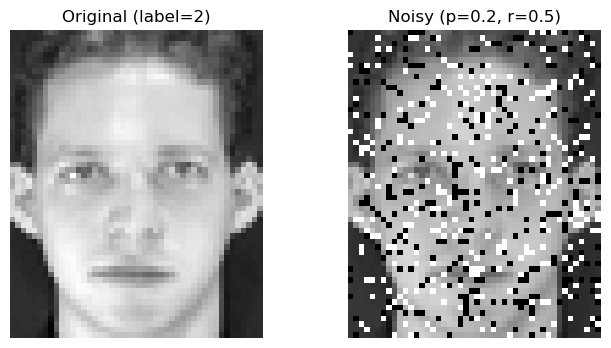

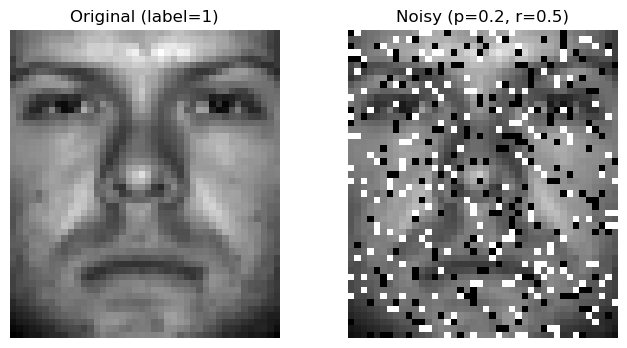

In [44]:
# ORL
X_orl, Y_orl = load_data(root='data/ORL', reduce=2)
add_noise_and_show_one(X_orl, Y_orl, datatype='data/ORL', reduce=2, idx=0)

# YaleB
X_yale, Y_yale = load_data(root='data/CroppedYaleB', reduce=4)
add_noise_and_show_one(X_yale, Y_yale, datatype='data/CroppedYaleB', reduce=4, idx=0)

## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


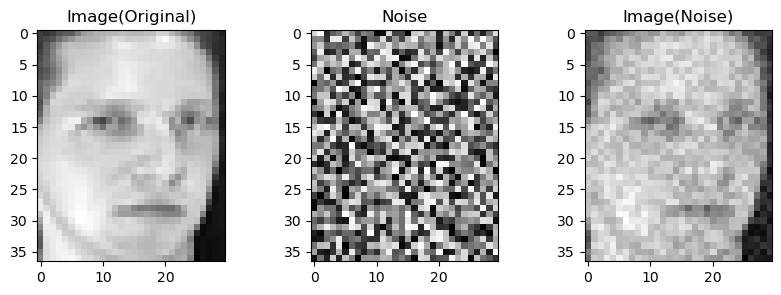

==> Apply NMF ...
W.shape=(1110, 40), H.shape=(40, 400)
==> Evaluate RRE ...
RRE = 0.3037247602927772


In [45]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
V_noise = np.random.rand(*V_hat.shape) * 40
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
from sklearn.decomposition import NMF
model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
W = model.fit_transform(V)
H = model.components_
print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

# Evaluate relative reconstruction errors.
print('==> Evaluate RRE ...')
RRE = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE))

In [46]:
def rre(V_hat: np.ndarray, W: np.ndarray, H: np.ndarray) -> float:
    """Relative Reconstruction Error"""
    num = np.linalg.norm(V_hat - W @ H, ord='fro')
    den = np.linalg.norm(V_hat, ord='fro') + 1e-12
    return float(num / den)

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [47]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.3350 (0.5296)


# 3. NMF core algorithm

## 3.1 L2-NMF (Frobenius) 

### Objective
Given a nonnegative data matrix $V\in\mathbb{R}_{+}^{d\times n}$, find
$W\in\mathbb{R}_{+}^{d\times k}$, $H\in\mathbb{R}_{+}^{k\times n}$ s.t.
$$
\min_{W\ge0,\,H\ge0}\ \|V-WH\|_F^2
= \sum_{i,j}\big(V_{ij}-(WH)_{ij}\big)^2 .
$$
Each column of $W$ is a **basis/part**, each column of $H$ is the **nonnegative code** of a sample.

### Multiplicative Updates (MU)
With $\widehat V = WH$ and small $\varepsilon>0$ (for division safety):
$$
\boxed{\,W \leftarrow W \odot \frac{V H^\top}{\widehat V H^\top+\varepsilon},\qquad
H \leftarrow H \odot \frac{W^\top V}{W^\top \widehat V+\varepsilon}\,}
$$
($\odot$ and the divisions are element-wise.)  
MU keeps nonnegativity and monotonically decreases $\|V-WH\|_F^2$.

### Normalization (for stability)
NMF is scale-ambiguous: $(WD)(D^{-1}H)$ yields the same product.  
After updating $W$, normalize its columns and absorb the scale into $H$:
$$
W \leftarrow W D^{-1},\qquad H \leftarrow D H,\quad
D=\operatorname{diag}(\mathbf{1}^\top W).
$$

### Stopping & Curve
Track $E_t=\|V-W_tH_t\|_F^2$. Stop when
$$
\frac{|E_t-E_{t-1}|}{E_{t-1}+\varepsilon} < \texttt{tol}.
$$
Plot $\{E_t\}$ as the **convergence curve** for L2-NMF.

In [48]:
def NMFL2(X: np.ndarray, k: int, max_iter: int = 300, tol: float = 1e-5, seed: int = 0
          ) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    L2-NMF (Frobenius) with multiplicative updates, ndarray-only.
    Return (W, H, error_curve), where error is Frobenius reconstruction loss.
    """
    rng = np.random.default_rng(seed)

    # --- ensure 2D float32 ndarray & nonnegative ---
    V = np.asarray(X, dtype=np.float32)
    if V.ndim != 2:
        # change it to (d, n) if other structure exists
        V = V.reshape(V.shape[0], -1)
    V = np.maximum(V, 0.0)
    m, n = V.shape
    r = int(k)

    # --- init ---
    W = np.abs(rng.standard_normal((m, r), dtype=np.float32)) + 1e-6
    H = np.abs(rng.standard_normal((r, n), dtype=np.float32)) + 1e-6
    # scaling W，update H
    scale = np.maximum(W.sum(axis=0, keepdims=True), 1e-12)
    W /= scale
    H *= scale.T   
 
    # Record the error
    errs: List[float] = []
    eps = 1e-12

    for _ in range(int(max_iter)):
        # Frobenius error
        E = V - W @ H
        err = float(np.linalg.norm(E, ord='fro')**2)
        errs.append(err)
        if len(errs) >= 2 and abs(errs[-1] - errs[-2]) / (errs[-2] + eps) < tol:
            break

        # update
        WH = W @ H
        W *= (V @ H.T) / (WH @ H.T + eps)
        W = np.maximum(W, 0.0)

        # scaling W，update H again
        scale = np.maximum(W.sum(axis=0, keepdims=True), 1e-12) 
        W /= scale
        H *= scale.T   

        WH = W @ H
        H *= (W.T @ V) / (W.T @ WH + eps)
        H = np.maximum(H, 0.0)

    return W.astype(np.float32, copy=False), H.astype(np.float32, copy=False), errs

## L1-NMF (IRLS) 

### Objective
Given a nonnegative data matrix $V\in\mathbb{R}^{d\times n}_{+}$, find
$W\in\mathbb{R}^{d\times k}_{+}$ and $H\in\mathbb{R}^{k\times n}_{+}$ that minimize the **L1** reconstruction error:
$$
\min_{W\ge0,\,H\ge0}\ \|V-WH\|_{1}
= \sum_{i,j}\big|V_{ij}-(WH)_{ij}\big|.
$$
L1 is more robust to sparse, large-magnitude outliers (e.g., salt-and-pepper noise).

### IRLS idea
Directly optimizing L1 is difficult. **IRLS** (Iteratively Reweighted Least Squares) approximates L1 by a sequence of **weighted L2** problems.  
Let the residual $R=V-WH$ and define per-pixel weights
$$
\Omega=\frac{1}{\sqrt{R\odot R+\varepsilon}},
$$
then
$$
\|V-WH\|_{1}\ \approx\ \sum_{i,j}\Omega_{ij}\,\big(V_{ij}-(WH)_{ij}\big)^2,
$$
with $\varepsilon>0$ as a smoothing/anti-division-by-zero constant. Fixing $\Omega$, we solve a weighted L2-NMF, then recompute $\Omega$, and iterate.

### Weighted MU updates
With $\widehat V=WH$ and element-wise operations,
$$
\boxed{\;
W \leftarrow W \odot \frac{(\Omega\odot V)H^\top}{(\Omega\odot \widehat V)H^\top+\varepsilon},\qquad
H \leftarrow H \odot \frac{W^\top(\Omega\odot V)}{W^\top(\Omega\odot \widehat V)+\varepsilon}\;
}
$$
After each update: clip tiny negatives to zero and **column-normalize $W$**, absorbing the scale into $H$ for numerical stability.

### Stopping & curve
Track the **MAE** (or L1) after each outer iteration:
$$
\text{MAE}_t=\frac{1}{dn}\sum_{i,j}\big|V_{ij}-(W_tH_t)_{ij}\big|.
$$
Stop when the **relative decrease** satisfies
$$
\frac{|\text{MAE}_t-\text{MAE}_{t-1}|}{\text{MAE}_{t-1}+\varepsilon}<\texttt{tol}.
$$

In [49]:
def NMFL1_IRLS(X: np.ndarray, k: int, max_iter: int = 100, inner_iters: int = 3, eps: float = 1e-8, tol: float = 1e-4, seed: int = 0):
    """
    L1-NMF via IRLS (Iteratively Reweighted Least Squares).
    Minimize  ||X - W H||_1  s.t. W >= 0, H >= 0

    Args:
        X:          (d, n) nonnegative data matrix 
        k:          dimensions
        max_iter:   iterate number
        inner_iters: Update steps（1~5）
        eps:        used in（Ω = 1/sqrt((X-WH)^2 + eps)）；also used to prevernt divided by 0
        tol:        stop value
        seed:       random seed

    Returns:
        W: (d, k) nonnegative dictionary 
        H: (k, n) nonnegative codes representations
        mae_curve: MAE value
    """
    rng = np.random.default_rng(seed)

    X = np.asarray(X, dtype=np.float32, order="F")  
    d, n = X.shape

    # Initialize
    W = np.abs(rng.standard_normal((d, k), dtype=np.float32)) + 1e-6
    H = np.abs(rng.standard_normal((k, n), dtype=np.float32)) + 1e-6
    # Sclae the column
    scale = np.maximum(W.sum(axis=0, keepdims=True), 1e-12)
    W /= scale
    H *= scale.T   

    mae_curve = []
    prev = np.inf
    tiny = 1e-12  

    for it in range(max_iter):
        # Calculate the residual & IRLS Ω
        R = X - (W @ H)                  
        Omega = 1.0 / np.sqrt(R*R + eps) 

        # --- keep Ω ，update weighted multiplycation 
        for _ in range(inner_iters):
            WH = W @ H

            # update W
            numW = (Omega * X) @ H.T                 # (d, k)
            denW = (Omega * WH) @ H.T + tiny         # (d, k)
            W *= numW / denW
            W = np.maximum(W, 0.0)

            # scaling W，H
            scale = np.maximum(W.sum(axis=0, keepdims=True), tiny)
            W /= scale
            H *= scale.T   

            # update H
            WH = W @ H
            numH = W.T @ (Omega * X)                 # (k, n)
            denH = W.T @ (Omega * WH) + tiny         # (k, n)
            H *= numH / denH
            H = np.maximum(H, 0.0)

        # --- calculate MAE ---
        mae = np.mean(np.abs(X - W @ H))
        mae_curve.append(mae)

        # check relative drop to determine when to stop
        if it > 0:
            rel_drop = abs(mae_curve[-2] - mae_curve[-1]) / (mae_curve[-2] + tiny)
            if rel_drop < tol:
                break

    return W.astype(np.float32, copy=False), H.astype(np.float32, copy=False), np.array(mae_curve, dtype=np.float32)

# 4. Main

Load and preprocess the data

In [50]:
def prepare_dataset(name: str):
    if name.lower() == 'orl':
        X, y = load_data(root='data/ORL', reduce=2)
    elif name.lower() in ('yaleb', 'extended yaleb', 'croppedyaleb'):
        X, y = load_data(root='data/CroppedYaleB', reduce=4)
    else:
        raise ValueError("unknown dataset name")

    # Scaling
    if X.max() > 1.0:
        X = X.astype(np.float32) / 255.0
    else:
        X = X.astype(np.float32)
    return X, y.astype(int)

Run NMFL2

In [51]:
def RUN_NMFL2(V, k, seed=0, max_iter=300, tol=1e-5):
    return NMFL2(V, k=k, max_iter=max_iter, tol=tol, seed=seed)

def RUN_NMFL1(V, k, seed=0, max_iter=100, inner_iters=3, eps=1e-8, tol=1e-4):
    return NMFL1_IRLS(V, k=k, max_iter=max_iter, inner_iters=inner_iters, eps=eps, tol=tol, seed=seed)


### Visulization

Turn column back to image

In [52]:
def _col_to_img(x: np.ndarray, h: int, w: int):
    """Trun (d,) or (d,1) column vector back to (h,w) image"""
    img = np.asarray(x).reshape(h, w)
    img = np.clip(img, 0.0, 1.0)
    return img

dictionary visulization

In [53]:
def show_dictionary(
    W: np.ndarray,
    h: int, w: int,
    ncols: int = 8,
    title: str | None = None,
    dataset: str | None = None,
    algo: str | None = None,
    k: int | None = None,
):
    """
    W: (d,k) dictionary；show k  columns grid image
    title: "ORL — L1-IRLS — Dictionary (W), k=40"
    """
    d, kW = W.shape
    nrows = int(np.ceil(kW / ncols))
    plt.figure(figsize=(1.8*ncols, 1.8*nrows))
    for i in range(kW):
        ax = plt.subplot(nrows, ncols, i+1)
        col = W[:, i]
        vmin, vmax = col.min(), col.max()
        img = _col_to_img((col - vmin) / (vmax - vmin + 1e-12), h, w)
        ax.imshow(img, cmap='gray'); ax.axis('off')

    if title is None:
        parts = []
        if dataset: parts.append(str(dataset))
        if algo:    parts.append(str(algo))
        left = " — ".join(parts) if parts else None
        right = f"Dictionary (W){', k='+str(k) if k is not None else ''}"
        title = f"{left} — {right}" if left else right

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Compare clean, noisy and recovered data

In [54]:
def show_reconstruction(
    X_clean: np.ndarray,
    X_noisy: np.ndarray,
    W: np.ndarray,
    H: np.ndarray,
    h: int, w: int,
    idx_list=None,
    title: str | None = None,
    dataset: str | None = None,
    algo: str | None = None,
    p: float | None = None,
    r: float | None = None,
):
    """
    Compare clean sample,sample with noisy and Recovered sample；
    Title:"ORL — L2 — Reconstruction (Original / Noisy / Recovered), p=0.2, r=0.5"
    """
    if idx_list is None:
        idx_list = list(range(6))
    WH = np.clip(W @ H, 0.0, 1.0)

    n = len(idx_list)
    plt.figure(figsize=(9, 3*n))
    for row, i in enumerate(idx_list):
        # Orginal one
        ax = plt.subplot(n, 3, 3*row+1)
        ax.imshow(_col_to_img(X_clean[:, i], h, w), cmap='gray')
        ax.set_title("Original"); ax.axis('off')
        # Noisy one
        ax = plt.subplot(n, 3, 3*row+2)
        ax.imshow(_col_to_img(X_noisy[:, i], h, w), cmap='gray')
        ax.set_title("Noisy"); ax.axis('off')
        # Revover one
        ax = plt.subplot(n, 3, 3*row+3)
        ax.imshow(_col_to_img(WH[:, i], h, w), cmap='gray')
        ax.set_title("Recovered"); ax.axis('off')

    if title is None:
        parts = []
        if dataset: parts.append(str(dataset))
        if algo:    parts.append(str(algo))
        left = " — ".join(parts) if parts else None
        prm = []
        if p is not None: prm.append(f"p={p}")
        if r is not None: prm.append(f"r={r}")
        right = "Reconstruction (Original / Noisy / Recovered)"
        if prm: right += ", " + ", ".join(prm)
        title = f"{left} — {right}" if left else right

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


learning curve

In [55]:
def plot_learning_curve(
    curve,
    ylabel: str = "Loss",
    title: str | None = None,
    dataset: str | None = None,
    algo: str | None = None,
    logy: bool = False,
):
    """
    curve: L2 using Frobenius loss；L1 using MAE
    Title: "ORL — L1-IRLS — Convergence"
    """
    y = np.asarray(curve).ravel()
    plt.figure(figsize=(5,3))
    if logy:
        plt.semilogy(y, lw=2)
        if ylabel.lower() == "loss": ylabel = "Loss (log)"
    else:
        plt.plot(y, lw=2)
    plt.xlabel("Outer Iteration"); plt.ylabel(ylabel)

    if title is None:
        parts = []
        if dataset: parts.append(str(dataset))
        if algo:    parts.append(str(algo))
        left = " — ".join(parts)
        title = f"{left} — Convergence" if left else "Convergence"

    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


RRE-vs-p curve

In [56]:
def plot_rre_vs_p(results_df, dataset: str, algo: str, R_list):
    """
    Using results_df to plot RRE - p plot；each line represent 1 r。
    """
    import matplotlib.pyplot as plt
    sub = results_df[(results_df["dataset"] == dataset) & (results_df["algo"] == algo)]
    ps = sorted(sub["p"].unique())
    plt.figure(figsize=(5.5,3.5))
    for r in R_list:
        s = sub[sub["r"] == r].sort_values("p")
        plt.errorbar(s["p"], s["RRE_mean"], yerr=s["RRE_std"], marker='o', capsize=3, label=f"r={r}")
    plt.xlabel("p (noise ratio)")
    plt.ylabel("RRE (mean ± std)")
    plt.title(f"{dataset} - {algo}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Main

In [57]:
def run_once(X_clean: np.ndarray,
             y: np.ndarray,
             algo_name: str,
             algo_fn,
             k: int,
             p: float,
             r: float,
             seed: int = 0)-> Tuple[float, Optional[float], Optional[float]]:
    """
    perform on 90% sample：sample → add noisy → NMF → performance
    - algo_fn: RUN_NMFL2 or RUN_NMFL1；return (W, H, curve)
    - return: (RRE, ACC, NMI)
    """
    rng = np.random.default_rng(seed)
    d, n = X_clean.shape

    # 1) 90% sample
    m = max(1, int(round(0.9 * n)))
    idx = rng.choice(n, size=m, replace=False)
    Xc = X_clean[:, idx]
    yc = y[idx]

    # 2) Add Noisy
    V_noisy, _ = salt_pepper(Xc, p=p, r=r, seed=seed)

    # 3) NMF 
    W, H, _ = algo_fn(V_noisy, k=k, seed=seed)

    # 4) RRE
    rre_val = rre(Xc, W, H)

    # 5) Clustering Performance
    acc = nmi = None
    y_pred = assign_cluster_label(H.T, yc)
    acc = accuracy_score(yc, y_pred)
    nmi = normalized_mutual_info_score(yc, y_pred)

    return float(rre_val), (None if acc is None else float(acc)), (None if nmi is None else float(nmi))

In [58]:
def demo_once(dataset="ORL", algo="L2", p=0.2, r=0.5, seed=0, show_k=6):
    # 1) read data & set image size
    X, y = prepare_dataset(dataset)
    if dataset.lower().startswith("orl"):
        h, w = 112//2, 92//2   
    else:
        h, w = 192//4, 168//4  

    # 2) using 90% sample
    rng = np.random.default_rng(seed)
    idx = rng.choice(X.shape[1], int(0.9*X.shape[1]), replace=False)
    Xc, yc = X[:, idx], y[idx]

    # 3) Add noisy
    tmp = salt_pepper(Xc, p=p, r=r, seed=seed)
    V = tmp[0] if isinstance(tmp, (tuple, list)) else tmp

    # 4) run algorithm & Plot the curve
    k = len(np.unique(yc))
    if algo == "L2":
        W, H, curve = RUN_NMFL2(V, k=k, seed=seed)
        plot_learning_curve(curve, ylabel="Frobenius loss", title=f"{dataset} {algo} Convergence")
    elif algo == "L1-IRLS":
        W, H, curve = RUN_NMFL1(V, k=k, seed=seed)
        plot_learning_curve(curve, ylabel="MAE", title=f"{dataset} {algo} Convergence")
    else:
        raise ValueError("algo must be 'L2' or 'L1-IRLS'")

    # 5) Addition Visualization
    show_dictionary(W, h, w, ncols=8, title=f"{dataset} {algo} Dictionary")
    show_reconstruction(Xc, V, W, H, h, w, idx_list=list(range(show_k)), title=f"{dataset} {algo} Demo")

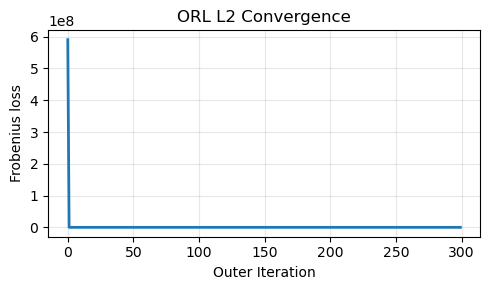

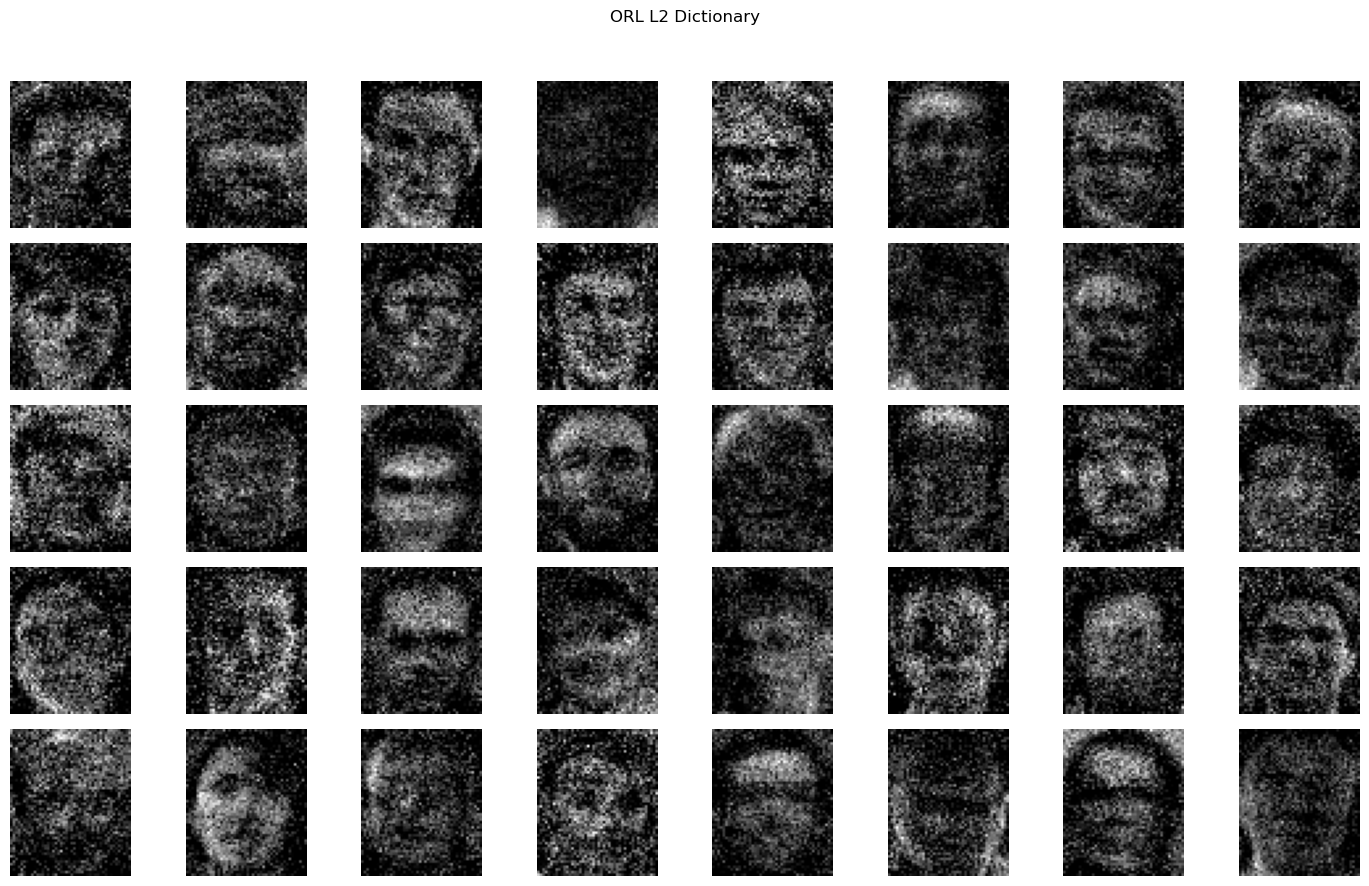

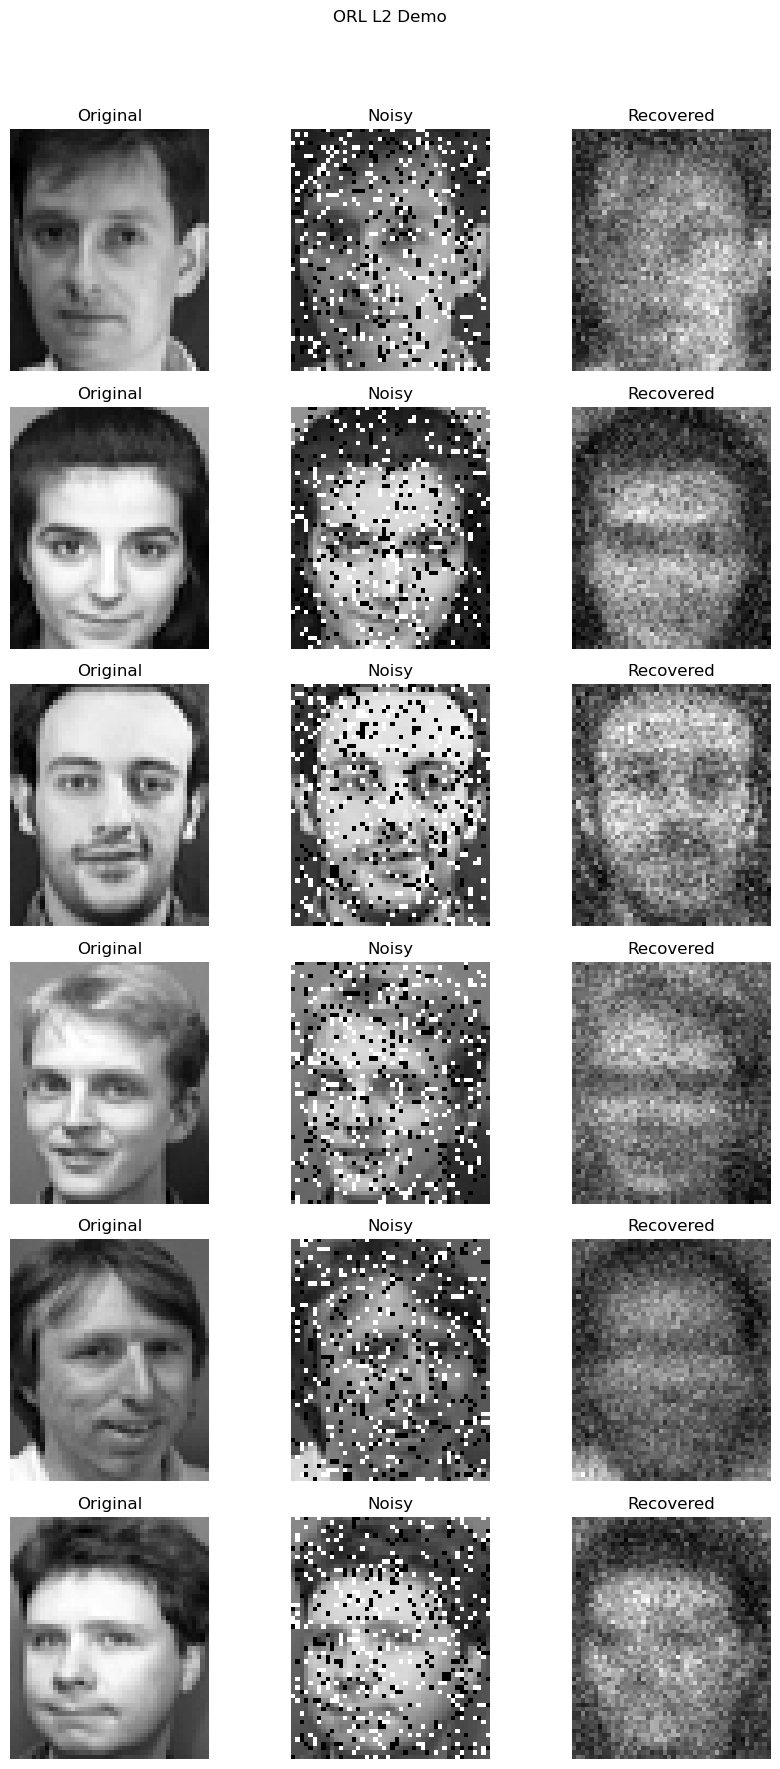

In [59]:
# ORL - L2
demo_once(dataset="ORL", algo="L2", p=0.2, r=0.5, seed=0, show_k=6)

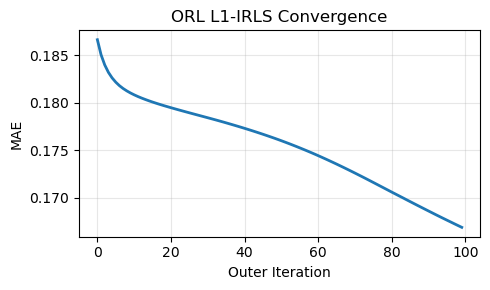

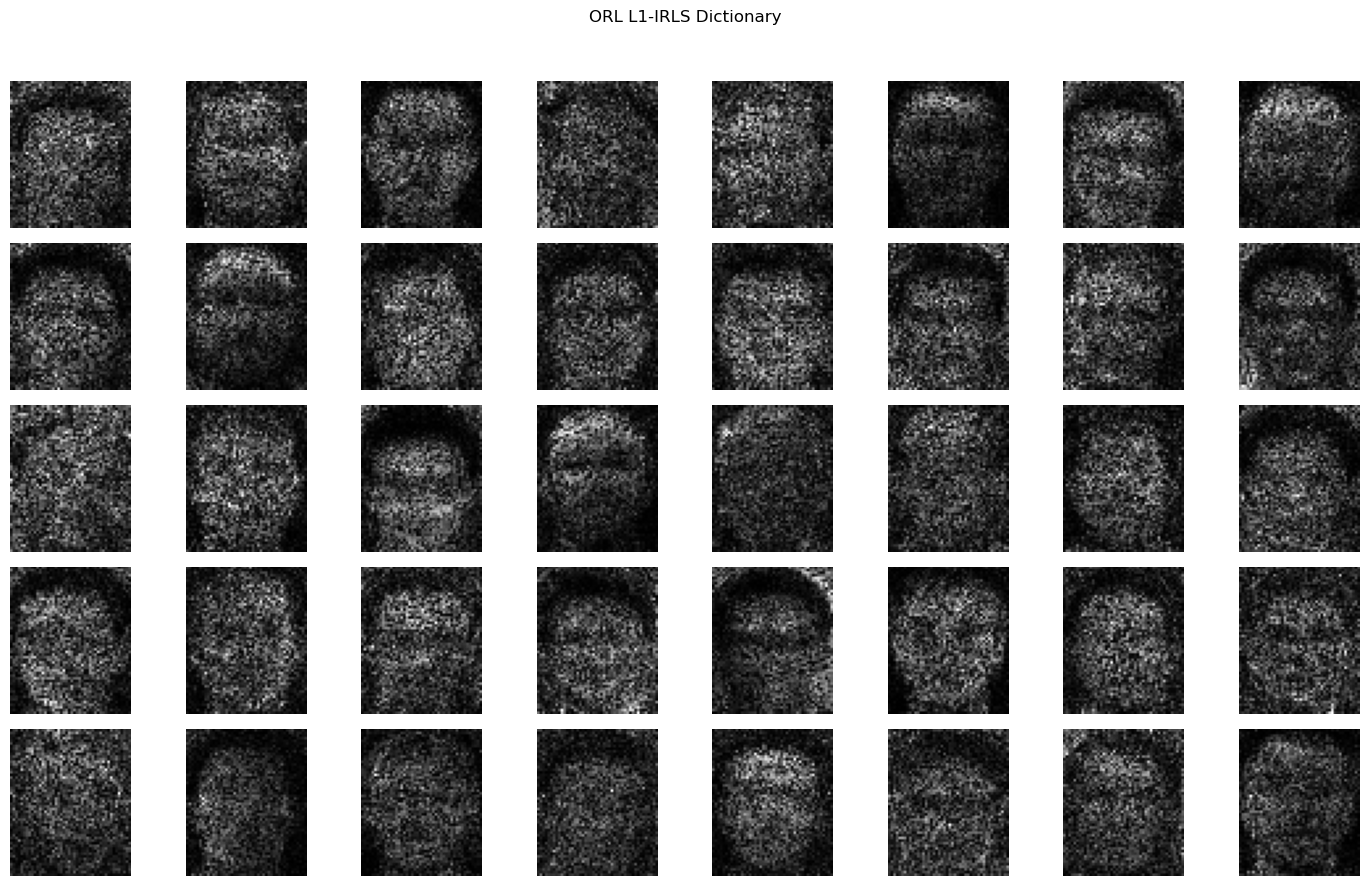

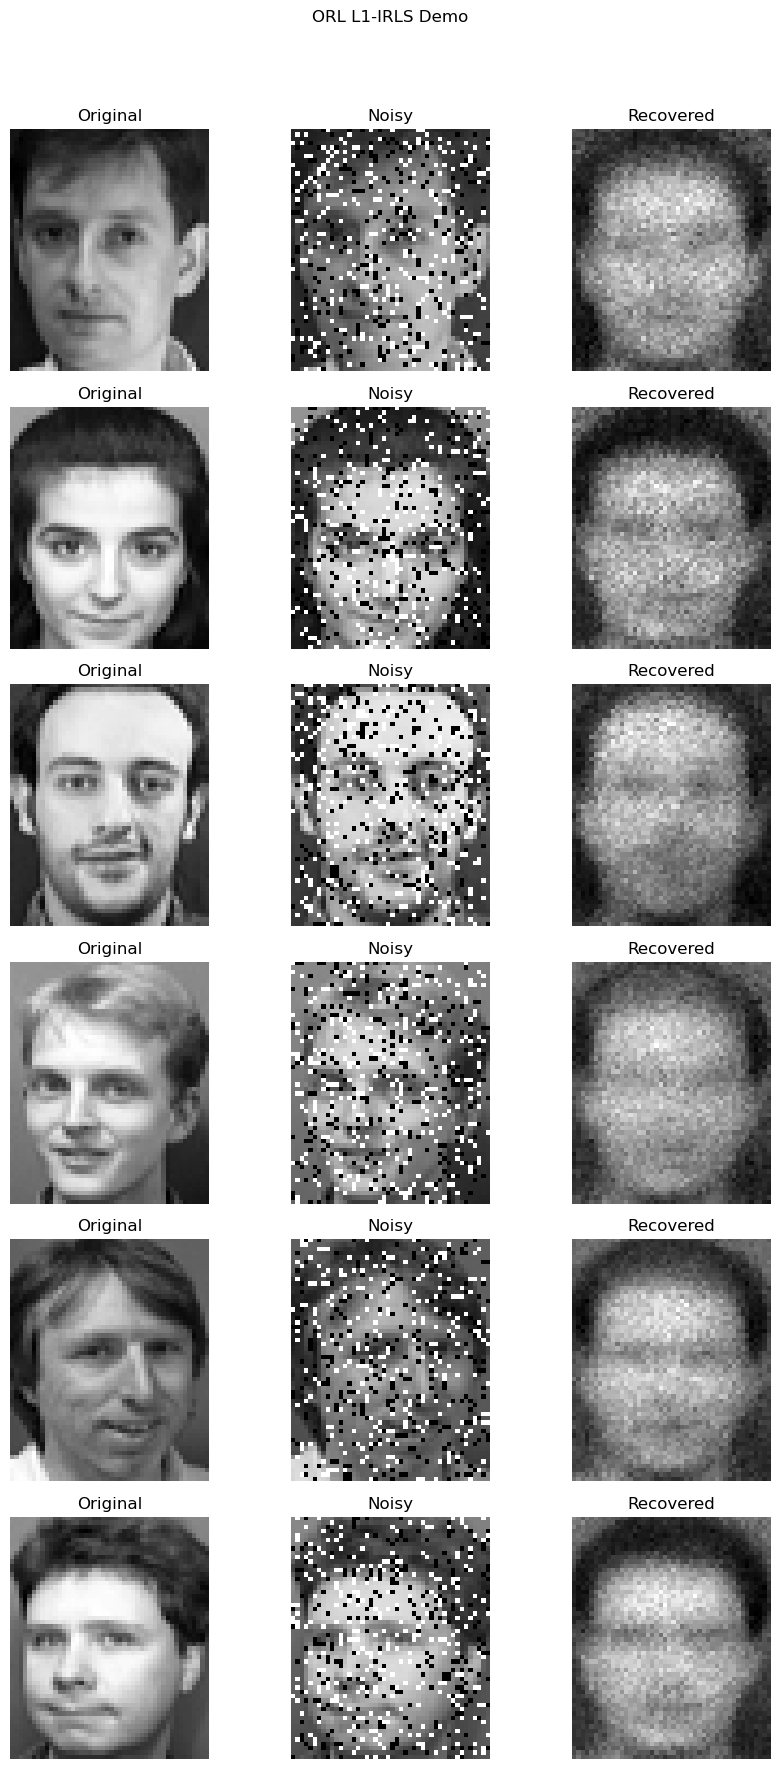

In [60]:
# ORL - L1
demo_once(dataset="ORL", algo="L1-IRLS", p=0.2, r=0.5, seed=0, show_k=6)

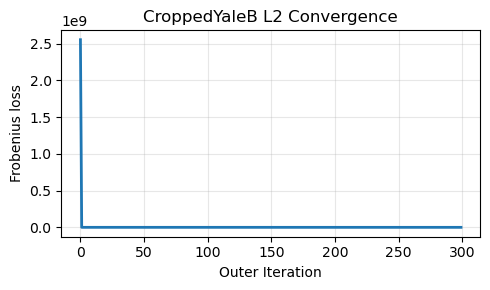

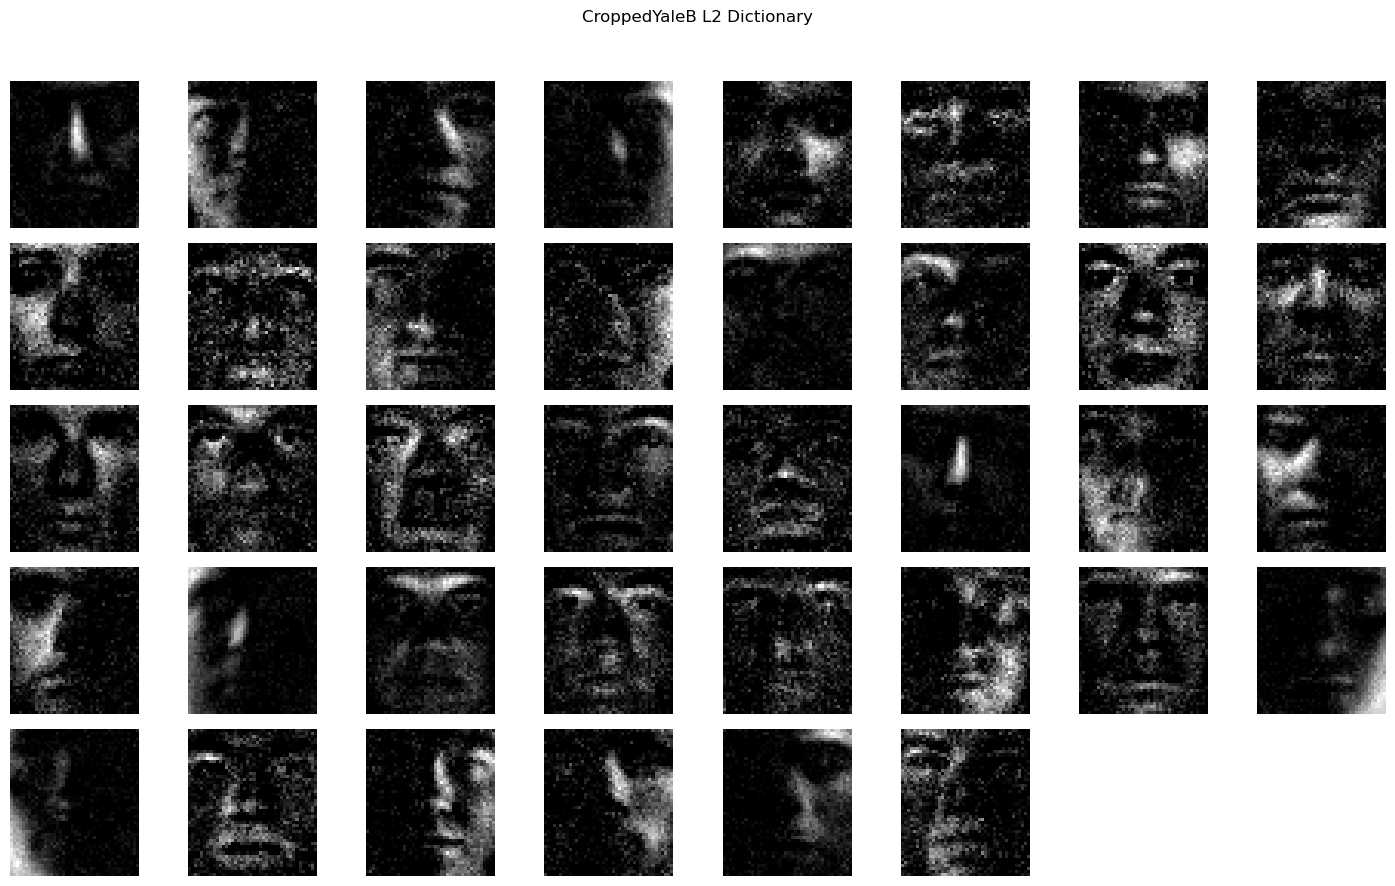

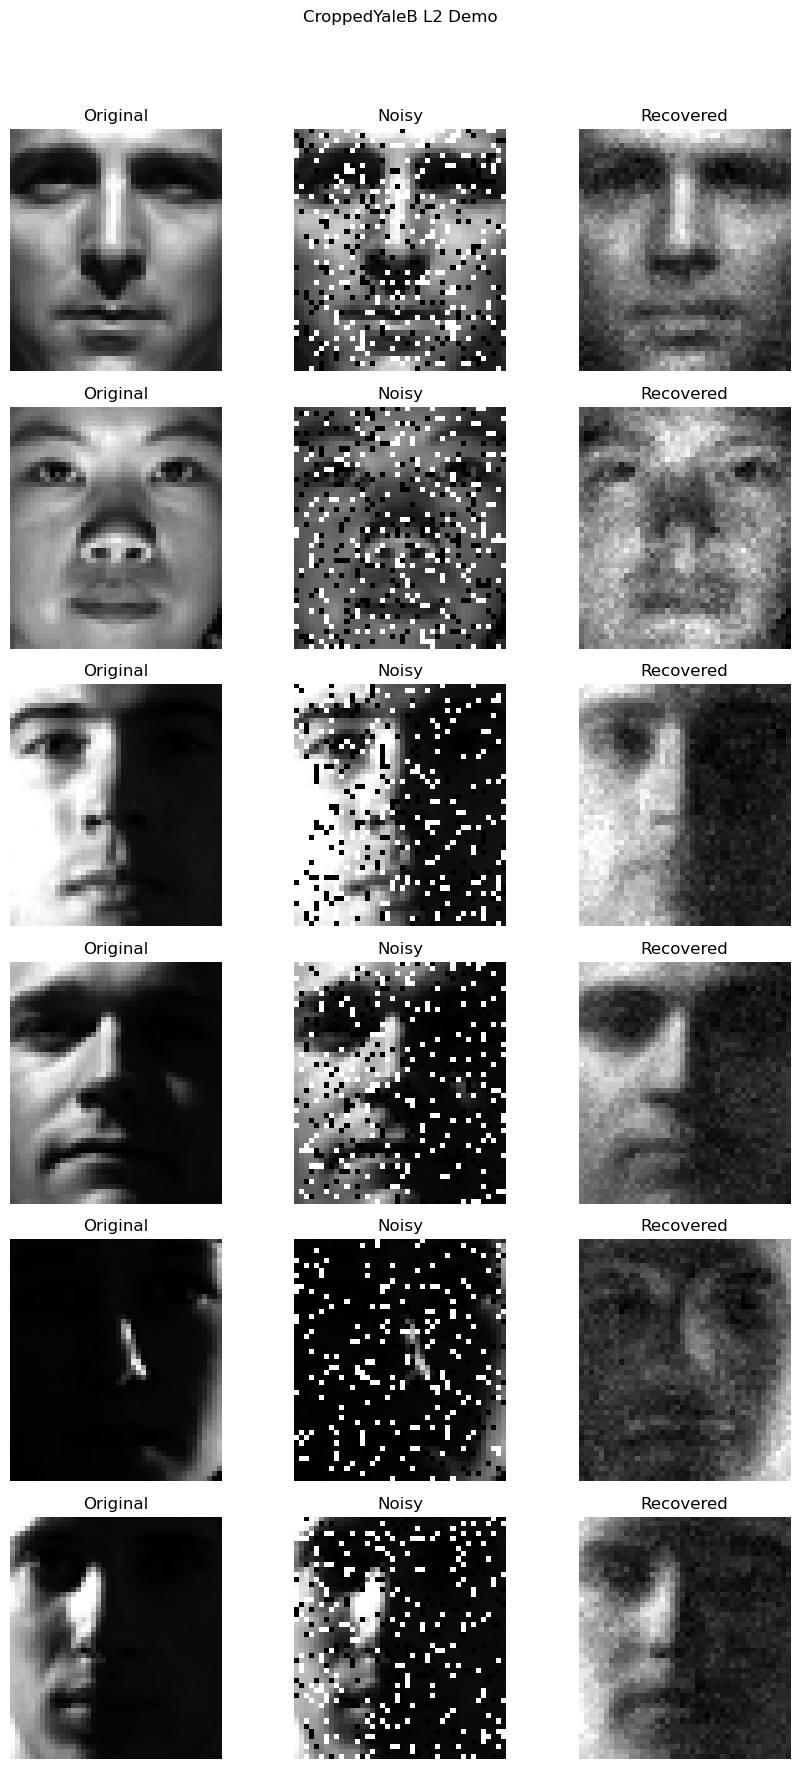

In [61]:
# CroppedYaleB - L2
demo_once(dataset="CroppedYaleB", algo="L2", p=0.2, r=0.5, seed=0, show_k=6)

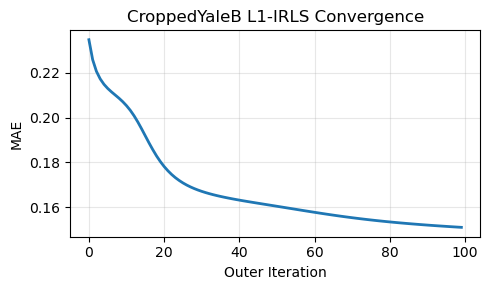

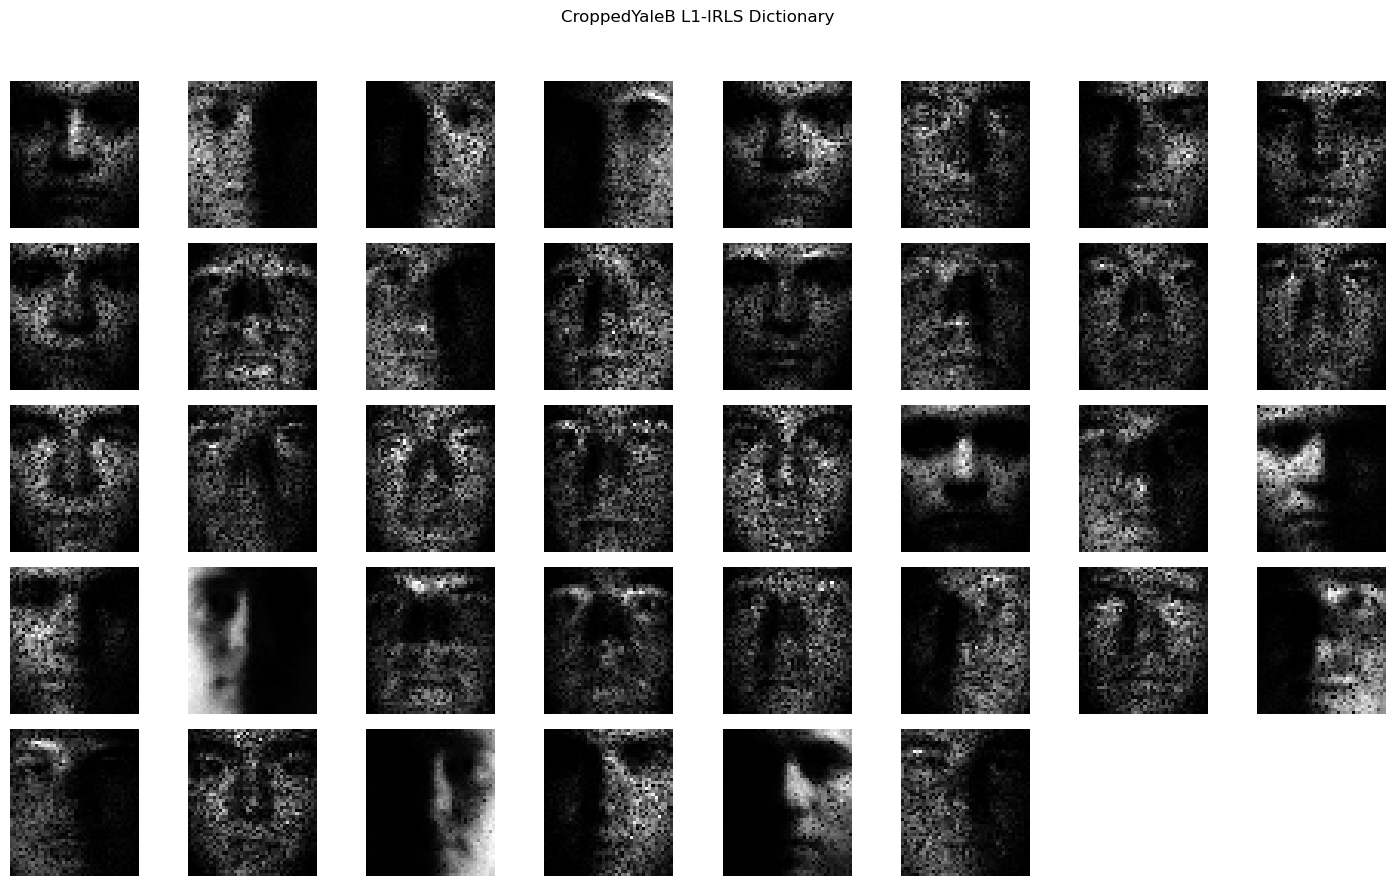

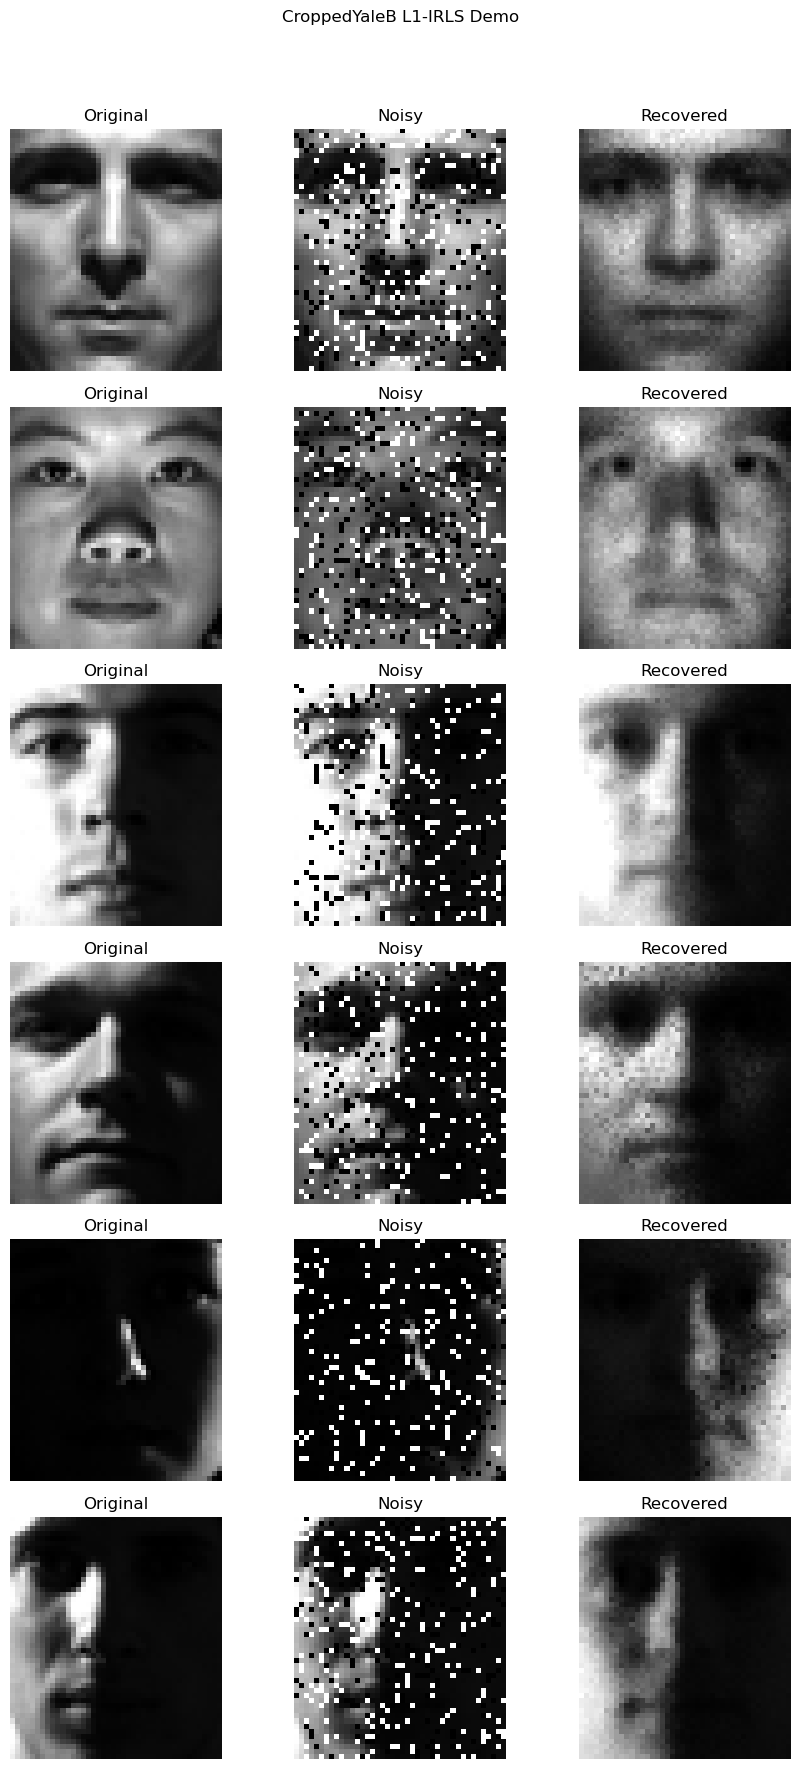

In [62]:
# CroppedYaleB - L1
demo_once(dataset="CroppedYaleB", algo="L1-IRLS", p=0.2, r=0.5, seed=0, show_k=6)

In [63]:
def run_experiment_for_dataset(
    dataset_name: str,
    P_list=(0.1, 0.2, 0.4),
    R_list=(0.3, 0.5, 0.7),
    repeats: int = 5,
    eval_cluster: bool = True,
    save_csv: bool = True,
):
    X_clean, y = prepare_dataset(dataset_name)
    k = len(np.unique(y))
    algos = {"L2": RUN_NMFL2, "L1-IRLS": RUN_NMFL1}

    all_rows = []
    print(f"[{dataset_name}] d={X_clean.shape[0]}, n={X_clean.shape[1]}, k={k}")

    for p in P_list:
        for r in R_list:
            for algo_name, algo_fn in algos.items():
                rre_vals, acc_vals, nmi_vals = [], [], []
                for t in range(repeats):
                    rre_val, acc, nmi = run_once(
                        X_clean, y, algo_name, algo_fn, k, p, r, seed=t
                    )
                    rre_vals.append(rre_val)
                    if eval_cluster:
                        acc_vals.append(acc); nmi_vals.append(nmi)
                row = {
                    "dataset": dataset_name, "p": float(p), "r": float(r), "algo": algo_name,
                    "RRE_mean": float(np.mean(rre_vals)), "RRE_std": float(np.std(rre_vals)),
                }
                if eval_cluster:
                    row.update({
                        "ACC_mean": float(np.mean(acc_vals)), "ACC_std": float(np.std(acc_vals)),
                        "NMI_mean": float(np.mean(nmi_vals)), "NMI_std": float(np.std(nmi_vals)),
                    })
                all_rows.append(row)
                print(f"  p={p:.2f}, r={r:.2f}, {algo_name}: RRE={row['RRE_mean']:.4f}±{row['RRE_std']:.4f}")

    df = pd.DataFrame(all_rows).sort_values(["dataset", "p", "r", "algo"])
    if save_csv:
        out_csv = f"results_{dataset_name.lower().replace(' ','_')}.csv"
        df.to_csv(out_csv, index=False)
        print("Saved CSV:", out_csv)
    return df

In [64]:
results_orl = run_experiment_for_dataset("ORL", P_list=[0.1,0.2,0.4], R_list=[0.3,0.5,0.7],
                                         repeats=5, eval_cluster=True, save_csv=True)
results_orl.head()

[ORL] d=2576, n=400, k=40
  p=0.10, r=0.30, L2: RRE=0.1897±0.0005
  p=0.10, r=0.30, L1-IRLS: RRE=0.2557±0.0027
  p=0.10, r=0.50, L2: RRE=0.1880±0.0005
  p=0.10, r=0.50, L1-IRLS: RRE=0.2587±0.0028
  p=0.10, r=0.70, L2: RRE=0.1937±0.0006
  p=0.10, r=0.70, L1-IRLS: RRE=0.2626±0.0033
  p=0.20, r=0.30, L2: RRE=0.2411±0.0008
  p=0.20, r=0.30, L1-IRLS: RRE=0.2598±0.0026
  p=0.20, r=0.50, L2: RRE=0.2352±0.0007
  p=0.20, r=0.50, L1-IRLS: RRE=0.2643±0.0032
  p=0.20, r=0.70, L2: RRE=0.2513±0.0009
  p=0.20, r=0.70, L1-IRLS: RRE=0.2745±0.0036
  p=0.40, r=0.30, L2: RRE=0.3411±0.0005
  p=0.40, r=0.30, L1-IRLS: RRE=0.2862±0.0035
  p=0.40, r=0.50, L2: RRE=0.3230±0.0003
  p=0.40, r=0.50, L1-IRLS: RRE=0.2800±0.0038
  p=0.40, r=0.70, L2: RRE=0.3650±0.0009
  p=0.40, r=0.70, L1-IRLS: RRE=0.3143±0.0022
Saved CSV: results_orl.csv


,dataset,p,r,algo,RRE_mean,RRE_std,ACC_mean,ACC_std,NMI_mean,NMI_std
1,ORL,0.1,0.3,L1-IRLS,0.255727,0.002690,0.360556,0.027633,0.549380,0.021965
0,ORL,0.1,0.3,L2,0.189690,0.000530,0.671111,0.028306,0.802201,0.012685
3,ORL,0.1,0.5,L1-IRLS,0.258717,0.002819,0.335556,0.016979,0.534216,0.020312
2,ORL,0.1,0.5,L2,0.188009,0.000485,0.691667,0.017303,0.825110,0.018745
5,ORL,0.1,0.7,L1-IRLS,0.262583,0.003296,0.318889,0.012222,0.522925,0.011078


In [65]:
results_yaleb = run_experiment_for_dataset("CroppedYaleB", P_list=[0.1,0.2,0.4], R_list=[0.3,0.5,0.7],
                                           repeats=5, eval_cluster=True, save_csv=True)
results_yaleb.head()

[CroppedYaleB] d=2016, n=2414, k=38
  p=0.10, r=0.30, L2: RRE=0.2140±0.0005
  p=0.10, r=0.30, L1-IRLS: RRE=0.2858±0.0016
  p=0.10, r=0.50, L2: RRE=0.2268±0.0011
  p=0.10, r=0.50, L1-IRLS: RRE=0.2845±0.0013
  p=0.10, r=0.70, L2: RRE=0.2513±0.0014
  p=0.10, r=0.70, L1-IRLS: RRE=0.2841±0.0011
  p=0.20, r=0.30, L2: RRE=0.2576±0.0012
  p=0.20, r=0.30, L1-IRLS: RRE=0.2915±0.0016
  p=0.20, r=0.50, L2: RRE=0.2953±0.0015
  p=0.20, r=0.50, L1-IRLS: RRE=0.2864±0.0017
  p=0.20, r=0.70, L2: RRE=0.3637±0.0017
  p=0.20, r=0.70, L1-IRLS: RRE=0.2867±0.0012
  p=0.40, r=0.30, L2: RRE=0.3771±0.0016
  p=0.40, r=0.30, L1-IRLS: RRE=0.3215±0.0023
  p=0.40, r=0.50, L2: RRE=0.4677±0.0022
  p=0.40, r=0.50, L1-IRLS: RRE=0.2937±0.0015
  p=0.40, r=0.70, L2: RRE=0.6208±0.0033
  p=0.40, r=0.70, L1-IRLS: RRE=0.3059±0.0011
Saved CSV: results_croppedyaleb.csv


,dataset,p,r,algo,RRE_mean,RRE_std,ACC_mean,ACC_std,NMI_mean,NMI_std
1,CroppedYaleB,0.1,0.3,L1-IRLS,0.285798,0.001647,0.085688,0.003207,0.081271,0.008334
0,CroppedYaleB,0.1,0.3,L2,0.214030,0.000513,0.227059,0.009950,0.306485,0.006695
3,CroppedYaleB,0.1,0.5,L1-IRLS,0.284530,0.001299,0.086516,0.003254,0.083536,0.002432
2,CroppedYaleB,0.1,0.5,L2,0.226765,0.001066,0.210953,0.003711,0.300122,0.006491
5,CroppedYaleB,0.1,0.7,L1-IRLS,0.284054,0.001075,0.085136,0.002521,0.079300,0.002633


In [66]:
# Combine two dataset together
frames = []
if 'results_orl'   in globals(): frames.append(results_orl)
if 'results_yaleb' in globals(): frames.append(results_yaleb)
if frames:
    results_df = pd.concat(frames, ignore_index=True)
    results_df = results_df.sort_values(["dataset", "p", "r", "algo"])
    results_df.to_csv("results_all.csv", index=False)
    results_df.head(12)

In [67]:
def plot_rre_vs_p(results_df, dataset: str, algo: str, R_list):
    sub = results_df[(results_df["dataset"] == dataset) & (results_df["algo"] == algo)]
    plt.figure(figsize=(5.5,3.5))
    for r in R_list:
        s = sub[sub["r"] == r].sort_values("p")
        plt.errorbar(s["p"], s["RRE_mean"], yerr=s["RRE_std"], marker='o', capsize=3, label=f"r={r}")
    plt.xlabel("p (noise ratio)"); plt.ylabel("RRE (mean ± std)")
    plt.title(f"{dataset} - {algo}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

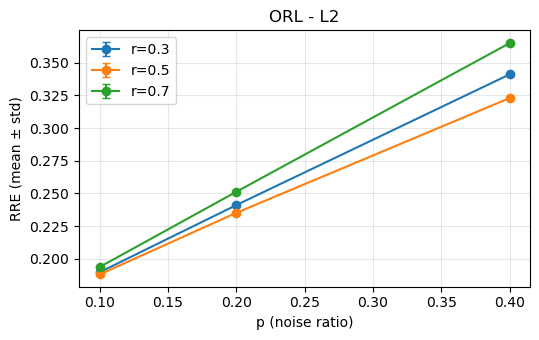

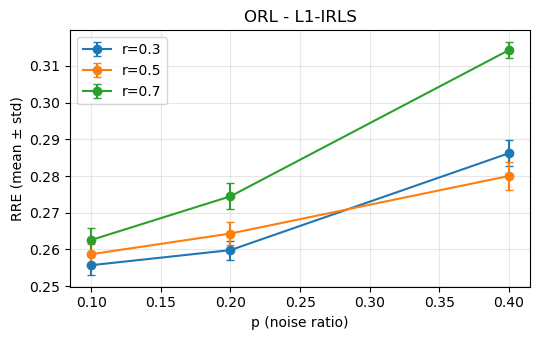

In [68]:
# Plot ORL
if 'results_orl' in globals():
    plot_rre_vs_p(results_orl, "ORL", "L2",      R_list=[0.3,0.5,0.7])
    plot_rre_vs_p(results_orl, "ORL", "L1-IRLS", R_list=[0.3,0.5,0.7])

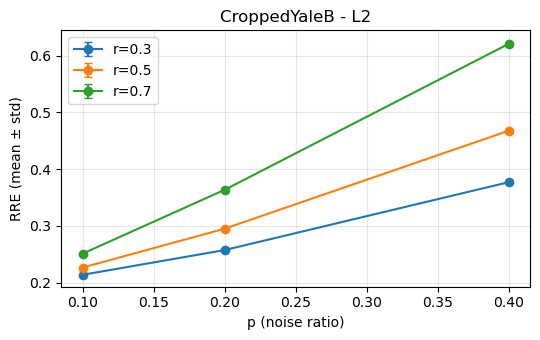

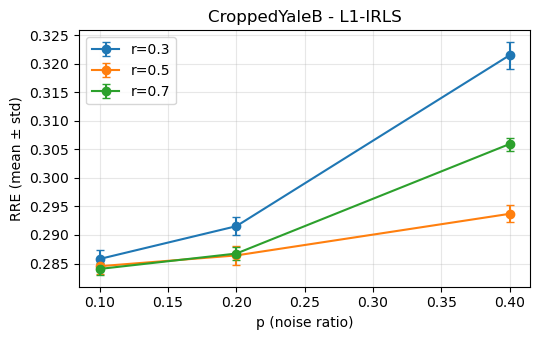

In [69]:
# Plot YaleB
if 'results_yaleb' in globals():
    plot_rre_vs_p(results_yaleb, "CroppedYaleB", "L2",      R_list=[0.3,0.5,0.7])
    plot_rre_vs_p(results_yaleb, "CroppedYaleB", "L1-IRLS", R_list=[0.3,0.5,0.7])